In [1]:

import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

img_width = 1920
img_height = 1080
image_dir = os.path.join("..", "soccernet_data", "tracking", "train", "SNMOT-060")

from data_loader import SoccerDatasetSequence, get_dataloader


batch_size = 3 
num_images_to_display = 2

od_dataloader = get_dataloader(
    sequence_dir=image_dir, 
    img_size=(img_height, img_width), 
    batch_size=batch_size, 
    shuffle=False # Keep shuffle=False if you want the *first* sequence elements
)

from featureExtractor import InceptionFeatureExtractor
img_data_all, gt_bboxes_all, gt_classes_all = next(iter(od_dataloader))
backbone = InceptionFeatureExtractor()
out = backbone(img_data_all)
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
# print('Out dims:', out_c, out_h, out_w)

width_scale_factor = img_width / out_w
height_scale_factor = img_height / out_h
# print(img_width, img_height, '->', out_w, out_h)


# height_scale_factor, width_scale_factor


img_size = (img_height, img_width)
out_size = (out_h, out_w)
out_channels = out_c
roi_size = (2, 2)
n_classes = 2
detector = TwoStageDetector(img_size, out_channels, n_classes, roi_size)

detector.to(device)
detector.eval() 


img_data_all_dev = img_data_all.to(device)
gt_bboxes_all_dev = gt_bboxes_all.to(device)
gt_classes_all_dev = gt_classes_all.long().to(device) # Ensure long type and device

with torch.no_grad(): # Use no_grad for evaluation/inference
    total_loss = detector(img_data_all_dev, gt_bboxes_all_dev, gt_classes_all_dev, device=device)
    proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all_dev, device=device)

print(f"Total Loss (Evaluation): {total_loss.item()}")




Using CUDA GPU


/home/das.ag/.conda/envs/cs6140_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/das.ag/.conda/envs/cs6140_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total Loss (Evaluation): 29.355886459350586


In [3]:
import torch
from tqdm import tqdm
import torch.optim as optim
from torch.amp import GradScaler, autocast # For mixed precision

def training_loop(model, learning_rate, train_dataloader, n_epochs, device):

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scaler = GradScaler(device=device.type) 

    model.to(device) # Move model to the selected device
    model.train()
    loss_list = []

    for i in range(n_epochs):
        print(f"Epoch {i+1}/{n_epochs}")
        total_loss = 0
        loop = tqdm(train_dataloader, leave=True)
        for img_batch, gt_bboxes_batch, gt_classes_batch in loop:

            # Move data to device
            img_batch = img_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            # ***** Ensure gt_classes are LongTensor and moved to device *****
            # Assuming gt_classes_batch is a tensor from the dataloader
            gt_classes_batch = gt_classes_batch.long().to(device)


            optimizer.zero_grad(set_to_none=True) # Use set_to_none=True for potential minor performance gain

            with autocast(device_type=device.type):
                loss = model(img_batch, gt_bboxes_batch, gt_classes_batch, device=device)

            if torch.isnan(loss):
                print("Warning: NaN loss detected. Skipping batch.")
                optimizer.zero_grad(set_to_none=True)
                continue

            # Scale loss and backpropagate
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            batch_loss = loss.item()
            total_loss += batch_loss

            # Update tqdm progress bar description
            loop.set_description(f"Epoch {i+1}")
            loop.set_postfix(loss=batch_loss)

        avg_epoch_loss = total_loss / len(train_dataloader)
        loss_list.append(avg_epoch_loss)
        print(f"Epoch {i+1} Average Loss: {avg_epoch_loss:.4f}")

    return loss_list

In [4]:
batch_size = 32

od_dataloader = get_dataloader(
    sequence_dir=image_dir, 
    img_size=(img_height, img_width), 
    batch_size=batch_size, 
    shuffle=True # Keep shuffle=False if you want the *first* sequence elements
)

learning_rate = 1e-2 # You might need to adjust this, especially with AMP
n_epochs = 5 
loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs, device)

detector.eval()
img_data_all = img_data_all.to(device)
with torch.no_grad():
    proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all, device=device)

loss_list

Epoch 1/5


Epoch 1: 100%|██████████| 24/24 [02:14<00:00,  5.62s/it, loss=21.3]   


Epoch 1 Average Loss: 15120.6974
Epoch 2/5


Epoch 2: 100%|██████████| 24/24 [02:18<00:00,  5.79s/it, loss=18.2]


Epoch 2 Average Loss: 20.6038
Epoch 3/5


Epoch 3: 100%|██████████| 24/24 [02:15<00:00,  5.63s/it, loss=17.9]


Epoch 3 Average Loss: 19.6126
Epoch 4/5


Epoch 4: 100%|██████████| 24/24 [02:16<00:00,  5.71s/it, loss=18.1]


Epoch 4 Average Loss: 19.4445
Epoch 5/5


Epoch 5: 100%|██████████| 24/24 [02:19<00:00,  5.81s/it, loss=20]  


Epoch 5 Average Loss: 19.4853


[15120.69736536344,
 20.6038232644399,
 19.612560669581097,
 19.44454511006673,
 19.485276381174724]

In [5]:
from datetime import datetime
date_time = datetime.now().strftime("%m_%d_%Y-%H:%M:%S")
torch.save(detector.state_dict(), f"checkpoints/checkpoint_model_{date_time}.pt")

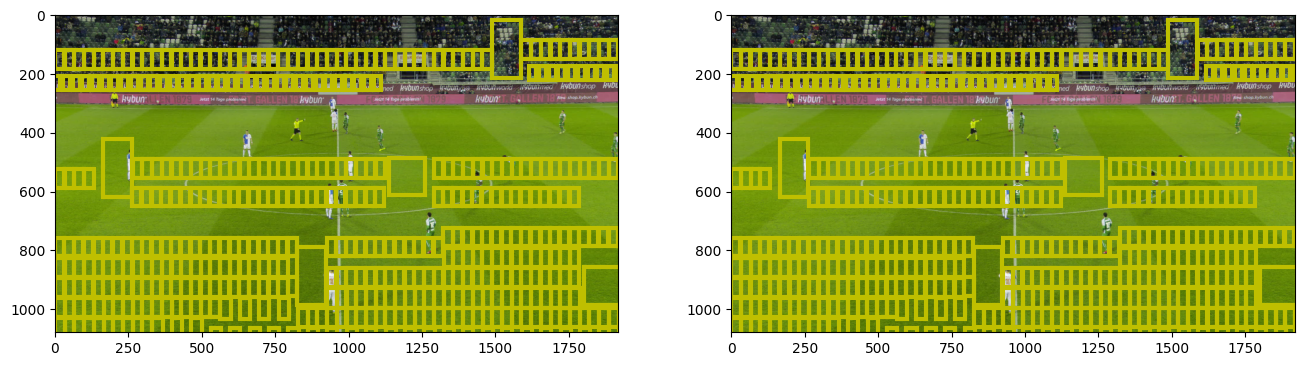

In [9]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all, device, conf_thresh=0.5, nms_thresh=0.0001)
proposals_final

width_scale_factor = img_width / out_w
height_scale_factor = img_height / out_h

prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p').cpu()
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p').cpu()
classes_pred_1 = ["player" for cls in classes_final[0].tolist()]
classes_pred_2 = ["player" for cls in classes_final[1].tolist()]

nimages = len(img_data_all)
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(img_data_all[:2], fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], )
fig, _ = display_bbox(prop_proj_2, fig, axes[1], )
plt.show()

